<a href="https://colab.research.google.com/github/Kira1108/huggingface-examples/blob/main/TokenClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Environment and python dependencies, google drive for persistent storage**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Package Installation**

In [2]:
from IPython.display import clear_output

!pip install transformers datasets
!pip install git+https://github.com/Kira1108/huggingface_utils.git
!mkdir data
!mv AirlineTweets.csv ./data

clear_output()

**Some helper functions for learning purpose.**

In [11]:
import inspect
import re
def view_object(obj, print_doc = False, pattern = None):

    pattern = re.compile(pattern) if pattern else re.compile(".*")

    print("Class", type(obj))
    print("-"*100)
    for attr in dir(obj):
        if attr.startswith("_") or not (pattern.search(attr)):
            continue
        if inspect.ismethod(getattr(obj, attr)):
            is_instance_method = getattr(obj, attr).__self__  == obj
            print(f"{attr}: {'instance method' if is_instance_method else 'classmethod[***]'}")
            doc = getattr(obj, attr).__doc__
            if doc and print_doc:
                print("-"*30)
                print(doc)
        else:
            print(f"{attr}: attribute")
        print("-"*100)

### Dataset

In [3]:
from datasets import load_dataset
from huggingface_utils.labels import LabelAligner

In [4]:
data = load_dataset("conll2003")
clear_output()

In [7]:
print(data)

print("\n\nTokens:")
print(data['train']['tokens'][:2])

print("\nPostags:")
print(data['train']['pos_tags'][:2])

print("\nChunktags:")
print(data['train']['chunk_tags'][:2])

print("\nNertags:")
print(data['train']['ner_tags'][:2])

print("\nTagsNames")
for task in['pos_tags','chunk_tags','ner_tags']:
    print(task,": ", data['train'].features[task].feature.names)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


Tokens:
[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['Peter', 'Blackburn']]

Postags:
[[22, 42, 16, 21, 35, 37, 16, 21, 7], [22, 22]]

Chunktags:
[[11, 21, 11, 12, 21, 22, 11, 12, 0], [11, 12]]

Nertags:
[[3, 0, 7, 0, 0, 0, 7, 0, 0], [1, 2]]

TagsNames
pos_tags :  ['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']


**Sentences is already splited into words.**    

IOB format is a sequence of labels  with one `Out` token and many `Begin` - `Inside` token pairs.   
This may cause problems when using subword tokenization
```python
chunk_tags =   ['O', 
               'B-ADJP', 'I-ADJP', 
               'B-ADVP', 'I-ADVP', 
               'B-CONJP', 'I-CONJP', 
               'B-INTJ', 'I-INTJ', 
               'B-LST', 'I-LST', 
               'B-NP', 'I-NP', 
               'B-PP', 'I-PP', 
               'B-PRT', 'I-PRT', 
               'B-SBAR', 'I-SBAR', 
               'B-UCP', 'I-UCP', 
               'B-VP', 'I-VP']
ner_tags = ['O', 
            'B-PER', 'I-PER', 
            'B-ORG', 'I-ORG', 
            'B-LOC', 'I-LOC', 
            'B-MISC', 'I-MISC']
```

### Tokenizer Issue    
- Add additional tokens like `[CLS]` and `[SEP]`
- Use subword tokenization, which may increase tokens compared to word tokenization
- mess up the original label

For more details, view 
[this repository](https://github.com/Kira1108/huggingface_utils/blob/main/huggingface_utils/labels/label_aligner.py)





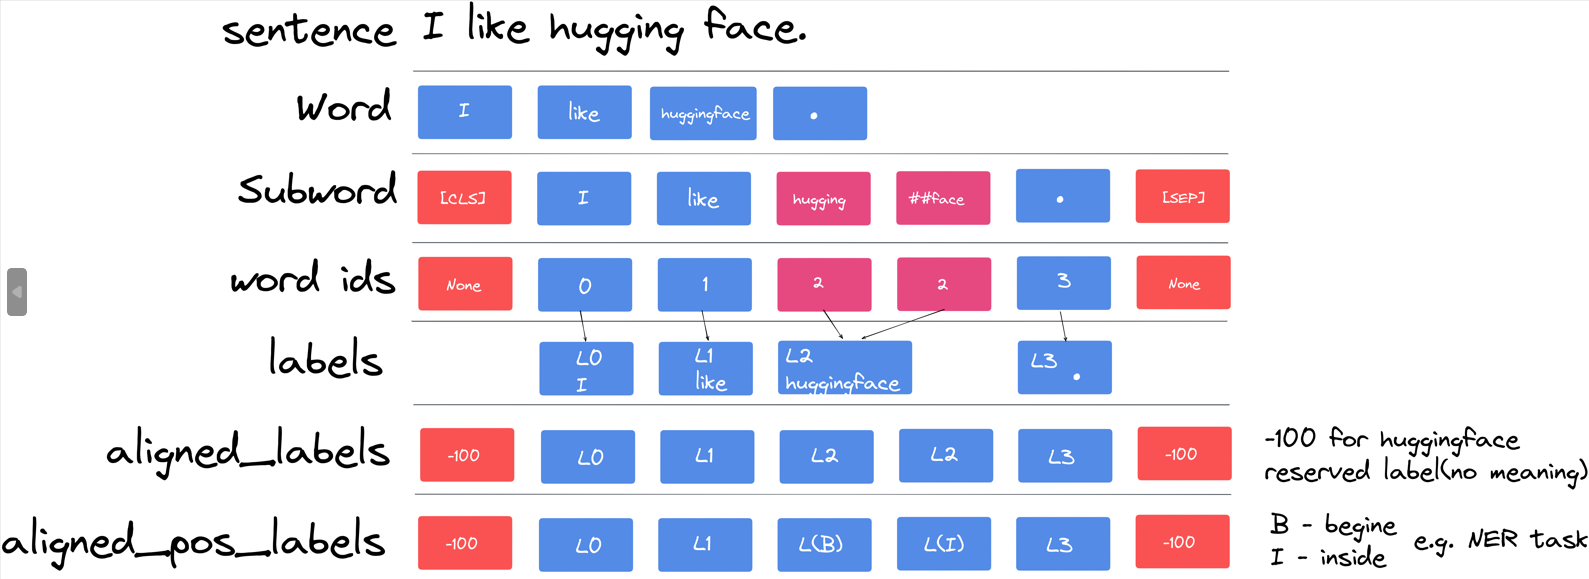

In [8]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

clear_output()

# view_object(tokenizer)

**Try tokenizer in different ways**   

Tokenize a single string
```python
t = tokenizer("I like huggingface, this is a great library. Unlike other deeplearning libraries, it encapsulated everything")

tokenizer_map = dict(zip(t.tokens(), t.word_ids()))
```

Tokenize a list of strings
```python
sentence = "I like huggingface, this is a great library. Unlike other deeplearning libraries, it encapsulated everything"

t = tokenizer(sentence.split(" "), is_split_into_words = True)
# You should notice how the word huggingface is tokenized by subword tokenization. 
tokenizer_map = dict(zip(t.tokens(), t.word_ids()))
```
     

Batch Encoding Object(`word_ids()` and `tokens` methods)
```python
t = tokenizer("I like huggingface, this is a great library. Unlike other deeplearning libraries, it encapsulated everything")

view_object(t)
```

**Align Non-IOB labels**

In [22]:
aligner = LabelAligner()

# these are labels human manually labled.
labels =     [       1,  0,      1,    1]

# word list generated by huggingface tokenizer
word_ids =   [None,  0,  1,  1,  2,    3,  None]

# labels that you want, for testing purpose
want_label = [-100,  1,  0,  0,  1,    1,  -100]

aligned_labels = aligner(labels, word_ids)

for l_want, l_aligned in zip(want_label, aligned_labels):
    assert l_want == l_aligned
    
print("Correctly aligned labels!")

Correctly aligned labels!


**Align IOB labels**

In [20]:
import random

label_names = data['train'].features['ner_tags'].feature.names
aligner = LabelAligner(label_names = label_names, use_iob = True)

# randomly choose a sample
idx = random.randint(0, data['train'].shape[0] - 1)

# original string token and labels
original_token = data['train']['tokens'][idx]
labels = data['train']['ner_tags'][idx]

# tokenizer batch encoding
t_batch_enc = tokenizer(data['train']['tokens'][idx], is_split_into_words = True)

# get word_ids and align_labels
word_ids = t_batch_enc.word_ids()
aligned_labels = aligner(labels = labels, word_ids = word_ids)

# convert things back
converted_tokens = tokenizer.convert_ids_to_tokens(t_batch_enc['input_ids'])
label_display = list(zip(converted_tokens, aligned_labels))
print("Oringinal Labels: ", labels)
print("Original Token: ", original_token)
print("Aligned Labels: ", label_display)

Oringinal Labels:  [0, 7, 0, 3, 4, 0, 0, 0, 5, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0]
Original Token:  ['The', 'Albanian', 'daily', 'Koha', 'Jone', 'reported', 'earlier', 'that', 'Greece', 'had', 'deported', 'about', '5,000', 'Albanians', 'in', 'the', 'last', 'five', 'days', '.']
Aligned Labels:  [('[CLS]', -100), ('The', 0), ('Albanian', 7), ('daily', 0), ('Ko', 3), ('##ha', 4), ('Jon', 4), ('##e', 4), ('reported', 0), ('earlier', 0), ('that', 0), ('Greece', 5), ('had', 0), ('deported', 0), ('about', 0), ('5', 0), (',', 0), ('000', 0), ('Albanian', 7), ('##s', 8), ('in', 0), ('the', 0), ('last', 0), ('five', 0), ('days', 0), ('.', 0), ('[SEP]', -100)]


**Summarize tokenizer part**

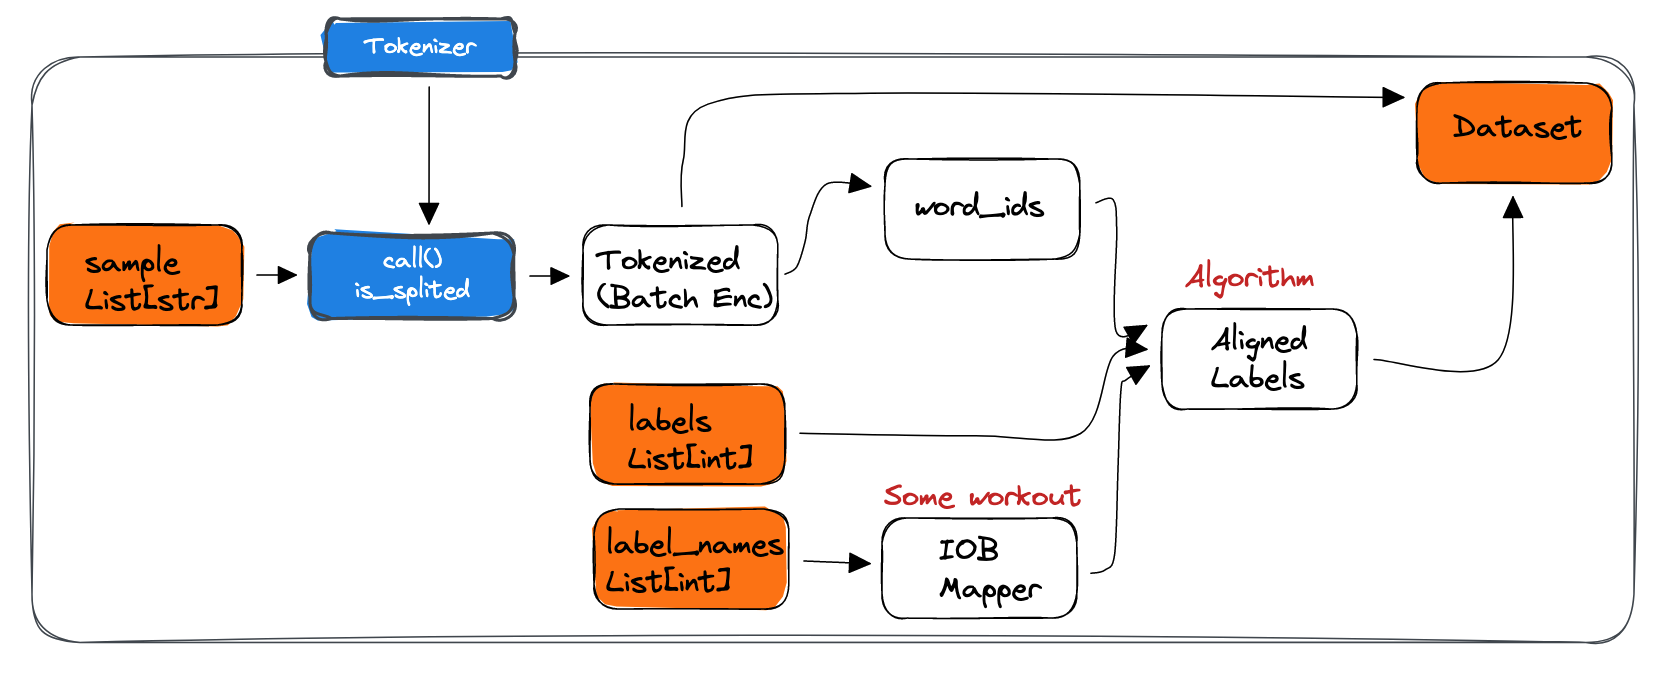